# [Carto Data Science Candidate Test](https://gist.github.com/andy-esch/29b215ac705a94ce59959347e3db0cfd)

#### Ethan Ebinger

*Every month New York City releases data about trips taken in NYC taxis. A new ride sharing company is your client. They are looking to start up a rival service to Uber or Lyft in NYC and are interested in using the Taxi Data to get insight into the transportation sector in New York. They have tasked you to get to know the data and start to build some simple models off of it.*

## TASK 1: Data exploration and cleaning

- *Download and assess the data*
- *Identify and document any issues with the data*
- *Document how you resolved these issues*

### import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import glob
import math
from datetime import datetime

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### import data

This data from: [NYC Taxi & Limousine Commission - Trip Record Data](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) and is described by the [data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

This notebook focuses on yellow cab data from the months of March, June, and November in 2017.

Each month contains nearly 1GB of data and will break my computer if processed at once, so for this exercise I use a random sample of 1,000,000 records from across the three months (there are ~30,000,000 total).

In [5]:
# load data
glob_files = glob.glob('data/yellow_tripdata_2017-*.zip')
taxi_trips = pd.concat((pd.read_csv(f) for f in glob_files)).reset_index()

In [6]:
# truncate data to a random sample of 1,000,000 records
# my computer can't process everything in memory :(
taxi_trips = taxi_trips.sample(1000000, replace=True).reset_index()
taxi_trips.drop(columns=['level_0', 'index'], inplace=True)

Let's peek behind the curtains before trying to clean anything.

In [7]:
taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               1000000 non-null  int64  
 1   tpep_pickup_datetime   1000000 non-null  object 
 2   tpep_dropoff_datetime  1000000 non-null  object 
 3   passenger_count        1000000 non-null  int64  
 4   trip_distance          1000000 non-null  float64
 5   RatecodeID             1000000 non-null  int64  
 6   store_and_fwd_flag     1000000 non-null  object 
 7   PULocationID           1000000 non-null  int64  
 8   DOLocationID           1000000 non-null  int64  
 9   payment_type           1000000 non-null  int64  
 10  fare_amount            1000000 non-null  float64
 11  extra                  1000000 non-null  float64
 12  mta_tax                1000000 non-null  float64
 13  tip_amount             1000000 non-null  float64
 14  tolls_amount       

In [8]:
taxi_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-06-24 22:41:16,2017-06-24 22:53:24,2,2.37,1,N,166,75,2,10.5,0.5,0.5,0.0,0.0,0.3,11.8
1,1,2017-03-20 19:21:20,2017-03-20 19:29:56,2,1.20,1,N,231,158,2,7.5,1.0,0.5,0.0,0.0,0.3,9.3
2,2,2017-03-16 11:27:21,2017-03-16 12:00:41,1,4.93,1,N,48,88,2,24.5,0.0,0.5,0.0,0.0,0.3,25.3
3,1,2017-11-30 22:11:16,2017-11-30 22:18:52,2,1.40,1,N,161,237,2,7.0,0.5,0.5,0.0,0.0,0.3,8.3
4,2,2017-11-29 08:39:15,2017-11-29 08:56:31,1,1.16,1,N,68,230,2,11.5,0.0,0.5,0.0,0.0,0.3,12.3


In [9]:
taxi_trips.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.546476,1.619503,2.927355,1.043603,163.139857,161.161949,1.329378,13.078764,0.334057,0.497322,1.875980,0.327935,0.299608,16.417622
std,0.497836,1.263657,7.542656,0.545868,66.605147,70.493175,0.490372,15.554992,0.471988,0.071366,2.654357,1.693069,0.014516,17.682433
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-152.000000,-53.710000,-0.500000,-1.170000,-15.000000,-0.300000,-152.800000
25%,1.000000,1.000000,0.980000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.360000,0.000000,0.300000,11.800000
75%,2.000000,2.000000,3.020000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.460000,0.000000,0.300000,17.850000
max,2.000000,9.000000,6545.780000,99.000000,265.000000,265.000000,4.000000,9999.990000,65.300000,54.510000,367.690000,555.540000,1.000000,9999.990000


Some oddities are popping out after calling the `.describe()` method. The first is that there are trips with negative values for some fields that should be only positive, such as `fare_amount`, `tip_amount`, and `tolls_amount`. Let's drop those records from the data.

In [10]:
taxi_trips = taxi_trips.loc[taxi_trips.fare_amount>=0].copy()
taxi_trips = taxi_trips.loc[taxi_trips.tip_amount>=0].copy()
taxi_trips = taxi_trips.loc[taxi_trips.tolls_amount>=0].copy()

There are also some curious values in the fields `extra` (which should "only includes the 0.50 and 1 rush hour and overnight charges"), `mta_tax` (flat 0.50 fee triggered based on metered rate), and `improvement_surcharge` (flat "0.30 improvement surcharge assessed trips at the flag drop"). Let's drop the records that do not have the proper flat fees in these columns.

In [11]:
taxi_trips = taxi_trips.loc[(taxi_trips.extra==0)|(taxi_trips.extra==0.5)|(taxi_trips.extra==1.0)].copy()
taxi_trips = taxi_trips.loc[(taxi_trips.mta_tax==0)|(taxi_trips.mta_tax==0.5)].copy()
taxi_trips = taxi_trips.loc[(taxi_trips.improvement_surcharge==0)|(taxi_trips.improvement_surcharge==0.3)].copy()

Let's also drop trips without passengers.

In [12]:
# drop trips that had no passengers
taxi_trips = taxi_trips.loc[taxi_trips.passenger_count>0].copy()

Additionally, there is at least one trip that traveled 0 miles! Trips cannot be trips if no distance was covered (possible that someone got in the cab, the taximeter was turned on, then then got out and decided to take another mode) so let's drop them from the dataset.

In [13]:
taxi_trips = taxi_trips.loc[taxi_trips.trip_distance>0].copy()

Let's check the trip times as well. If there are errors for trips with no distance there may also be trips that are less than a minute long and can be dropped from the data.

In [14]:
# convert pickup and dropff times to datetimes
for field in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
    taxi_trips[field] = taxi_trips[field].astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    
# create field for travel time (in seconds)
taxi_trips['travel_time'] = taxi_trips.tpep_dropoff_datetime - taxi_trips.tpep_pickup_datetime
taxi_trips['travel_time'] = taxi_trips['travel_time'].apply(lambda x: x.total_seconds())

In [15]:
# drop trips that had no travel time
taxi_trips = taxi_trips.loc[taxi_trips.travel_time>0].copy()

In [16]:
# create field for average trip speed (mph)
taxi_trips['avg_speed'] = (taxi_trips['trip_distance']/taxi_trips['travel_time'])*3600

In [17]:
# describe average speed
taxi_trips['avg_speed'].describe()

count    987047.000000
mean         12.863597
std         141.815805
min           0.001679
25%           7.144090
50%           9.750813
75%          13.314585
max       42120.000000
Name: avg_speed, dtype: float64

Hmmmm, it looks like at least one trip broke Mach 1. NYC cabs may be known to speed but they definitely aren't averaging over 60mph per trip. Let's drop all the supersonic records.

In [18]:
# drop trips that had unreasonable speeds
taxi_trips = taxi_trips.loc[taxi_trips.avg_speed<60].copy()

In [19]:
# describe average speed
taxi_trips['avg_speed'].describe()

count    986097.000000
mean         11.046309
std           5.943891
min           0.001679
25%           7.141700
50%           9.745223
75%          13.298507
max          59.381443
Name: avg_speed, dtype: float64

What about the really slow trips? Let's leave those because people may have hired taxis to sit idle. Personally I don't have that kind of money but no point in throwing out valid data.

Recalculate `total_amount` as `sum_total` to remove addition errors that may have occured. The field is not supposed to include cash amounts so it is unclear where the discrepencies are coming from.

In [20]:
# calculate total fare, rounded to two decimal places
taxi_trips['sum_total'] = (taxi_trips.fare_amount + taxi_trips.extra + taxi_trips.mta_tax + \
                          taxi_trips.improvement_surcharge + taxi_trips.tip_amount + taxi_trips.tolls_amount).round(2)

Lastly, let's drop any possible remaining null values, and then describe the data again.

In [21]:
# drop null records
taxi_trips.dropna(inplace=True)

# describe the dataframe
taxi_trips.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,travel_time,avg_speed,sum_total
count,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000,986097.000000
mean,1.548444,1.624064,2.878702,1.029096,163.156282,161.091763,1.324773,12.847354,0.317556,0.498477,1.846018,0.308609,0.299992,16.121960,1003.994521,11.046309,16.118008
std,0.497648,1.264599,3.618267,0.230418,66.608646,70.493761,0.483874,10.823921,0.371107,0.027550,2.521474,1.652460,0.001540,13.437563,3342.814369,5.943891,13.435584
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001679,0.000000
25%,1.000000,1.000000,0.990000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,406.000000,7.141700,8.750000
50%,2.000000,1.000000,1.620000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.360000,0.000000,0.300000,11.800000,680.000000,9.745223,11.800000
75%,2.000000,2.000000,3.000000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,1118.000000,13.298507,17.800000
max,2.000000,8.000000,197.280000,6.000000,265.000000,265.000000,4.000000,490.000000,1.000000,0.500000,367.690000,555.540000,0.300000,589.340000,86396.000000,59.381443,589.340000


A lot better. I am feeling comfortable moving forward with those values. 

Below is a function repeating the steps from above in case we need to load (and clean) more data in below

In [22]:
def clean_taxi_data(df):
    
    # drop null records
    df.dropna(inplace=True)
    
    # drop records with negative fares, tips, and tolls
    df = df.loc[(df.fare_amount>=0) & 
                      (df.tip_amount>=0) & 
                      (df.tolls_amount>=0)].copy()

    # drop records with erroneous fixed-rate values
    df = df.loc[(df.extra==0)|(df.extra==0.5)|(df.extra==1.0)].copy()
    df = df.loc[(df.mta_tax==0)|(df.mta_tax==0.5)].copy()
    df = df.loc[(df.improvement_surcharge==0)|(df.improvement_surcharge==0.3)].copy()

    # drop trips that had no passengers
    df = df.loc[df.passenger_count>0].copy()
    
    # drop records with no distance travelled
    df = df.loc[df.trip_distance>0].copy()

    # convert pickup and dropoff times to datetimes
    df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].astype(str).apply(lambda x: 
                                        datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].astype(str).apply(lambda x: 
                                        datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

    # calculate travel times in seconds)
    df['travel_time'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['travel_time'] = df['travel_time'].apply(lambda x: x.total_seconds())

    # drop trips that had no travel time
    df = df.loc[df.travel_time>0].copy()

    # create field for average trip speed (mph)
    df['avg_speed'] = (df['trip_distance']/df['travel_time'])*3600

    # drop records with impossible speeds
    df = df.loc[df.avg_speed<60].copy()

    # recalculate total fare, rounded to two decimal places
    df['sum_total'] = (df.fare_amount + df.extra + df.mta_tax + \
                       df.improvement_surcharge + df.tip_amount + df.tolls_amount).round(2)

    # return cleaned data
    return(df.copy())

## TASK 2: Data Summary

*Create a brief report that summarizes the core features of the data and calls out interesting trends, etc. This can be in the form of a notebook-like document (Jupyter, RMarkdown, etc.) or a slide deck. The audience for this should be other data scientists who need to understand that dataset.*

#### Frequency of tips

We are interested in creating a model that predicts how much riders tip their drivers. According to the data dictionary the `tip_amount` field "is automatically populated for credit card tips. Cash tips are not included." Let's see how trips are paid and then see the distribution of tips.

In [23]:
print("Credit card =", len(taxi_trips.loc[taxi_trips.payment_type==1]))
print("Cash =", len(taxi_trips.loc[taxi_trips.payment_type==2]))
print("No charge =", len(taxi_trips.loc[taxi_trips.payment_type==3]))
print("Dispute =", len(taxi_trips.loc[taxi_trips.payment_type==4]))
print("Unknown =", len(taxi_trips.loc[taxi_trips.payment_type==5]))
print("Voided Trip =", len(taxi_trips.loc[taxi_trips.payment_type==6]))

Credit card = 671971
Cash = 309178
No charge = 3764
Dispute = 1184
Unknown = 0
Voided Trip = 0


The cash trips all have no tips. We don't know if poeple who paid by cash left a tip  or now so they are going to skew our model tpowards a lower tip if they are left in. Let's drop these values from our data and then plot our data.

In [24]:
# drop cash trips from dataset
taxi_trips = taxi_trips.loc[taxi_trips.payment_type!=2].copy()

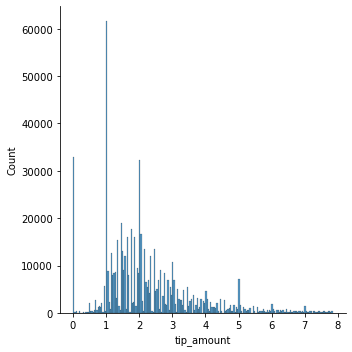

In [25]:
# histogram of tips
sns.displot(taxi_trips.loc[(taxi_trips.tip_amount<taxi_trips.tip_amount.quantile(0.95))], x="tip_amount")

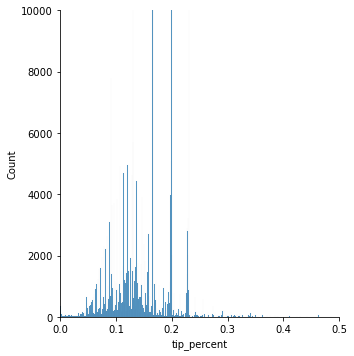

In [26]:
# tip percent
taxi_trips['tip_percent'] = taxi_trips.tip_amount / taxi_trips.total_amount
g = sns.displot(data=taxi_trips, x="tip_percent")
g.set(xlim=(0,0.5))
g.set(ylim=(0,10000))

When paying with credit card most people do tip. What is intersting is that people appear to prefer integer tip values: there are spikes in the number of trips tipping 1, 2, 3, 4, and 5 dollars. Customary tip percentages also show in the data, with many riders leaving 18% or 20% tips. However, many are more frugal.

In [27]:
print("mean tip (dollars):", "${:.2f}".format(taxi_trips.tip_amount.mean()))
print("mean tip (percent):", "{:.2f}%".format(taxi_trips.tip_percent.mean()*100))

mean tip (dollars): $2.69
mean tip (percent): 15.32%


#### Trip distances and travel times

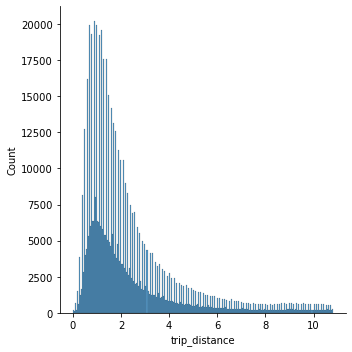

In [28]:
sns.displot(data=taxi_trips.loc[(taxi_trips.trip_distance<taxi_trips.trip_distance.quantile(0.95))],
            x="trip_distance")

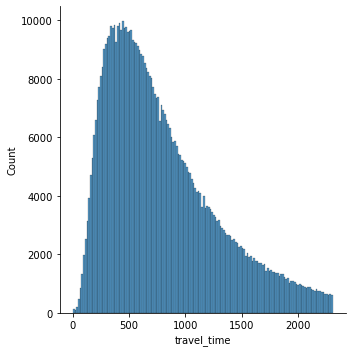

In [29]:
sns.displot(data=taxi_trips.loc[(taxi_trips.travel_time<taxi_trips.travel_time.quantile(0.95))],
            x="travel_time")

Many trips in New York City are only going about 1 mile and traveleing less than 10 minutes. Personally this seems odd given the frequency and accessibliity of the subway but we cannot identify trip purpose from this data. It is possible that people are using taxis becase of public transit delays, because they are carrying bags, or because they do not feel comfortable on the train.

Fares vary by distance and travel time, but what about tips?

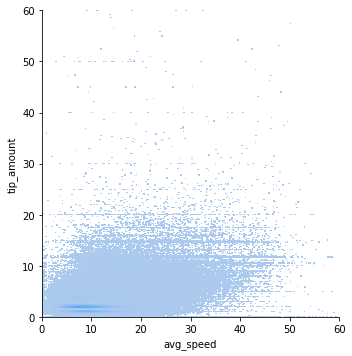

In [30]:
# tips by speed (distance/time)
g = sns.displot(data=taxi_trips, x="avg_speed", y="tip_amount")
g.set(xlim=(0,60))
g.set(ylim=(0,60))

Do tips vary by the number of passengers in the car?

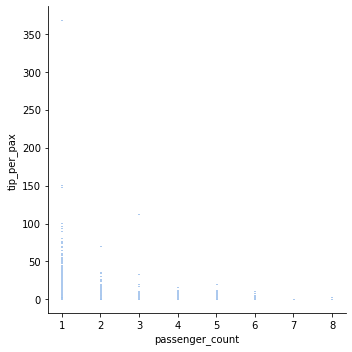

In [31]:
# tips by passenger
taxi_trips['tip_per_pax'] = taxi_trips.tip_amount / taxi_trips.passenger_count
sns.displot(data=taxi_trips, x="passenger_count", y="tip_per_pax")

Note for NYC yelow cab drivers: pick up solo passengers if you want to get bigger tips!

#### Mapping trips in space

I find it useful to visualize where trips are happening. The NYC taxi & Limousine Commission provides a shapefile with zones where trips started or ended. Let's join this with our trip data, and then create some maps and tables displaying how poeple moved around.

In [32]:
# load shapefile with taxi zones
taxi_zones = gpd.read_file('https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip')

In [33]:
# tag data with pickup zone and borough 
taxi_trips = taxi_trips.merge(taxi_zones[['LocationID', 'zone', 'borough']], 
                              left_on='PULocationID', right_on='LocationID', how='left')
taxi_trips.rename(columns={'borough':'PU_borough', 'zone':'PU_zone'}, inplace=True)
taxi_trips.drop(columns=['LocationID'], inplace=True)

# tag data with dropoff zone and borough 
taxi_trips = taxi_trips.merge(taxi_zones[['LocationID', 'zone', 'borough']], 
                              left_on='DOLocationID', right_on='LocationID', how='left')
taxi_trips.rename(columns={'borough':'DO_borough', 'zone':'DO_zone'}, inplace=True)
taxi_trips.drop(columns=['LocationID'], inplace=True)

In [34]:
# airport trip
taxi_trips['airport'] = np.where(taxi_trips.PU_zone.str.contains("Airport", na=False),1,0)
taxi_trips['airport'] = np.where(taxi_trips.DO_zone.str.contains("Airport", na=False),1,taxi_trips['airport'])

# trip starts/ends outside NYC (including airports)
taxi_trips['extrazonal'] = np.where(taxi_trips.PU_borough.isna(),1,0)
taxi_trips['extrazonal'] = np.where(taxi_trips.DO_borough.isna(),1,taxi_trips['extrazonal'])

# intra- and inter-borough trips (excluding airports)
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
for borough in boroughs:
    taxi_trips["intra_"+borough] = np.where(taxi_trips.PU_borough==borough,
                                       np.where(taxi_trips.DO_borough==borough,
                                                np.where(taxi_trips.airport==0,1,0),0),0)
    taxi_trips["inter_"+borough] = np.where(taxi_trips.PU_borough==borough,
                                       np.where(taxi_trips.DO_borough!=borough,
                                                np.where(taxi_trips.airport==0,1,0),0),0)

In [35]:
taxi_trips[['airport', 'extrazonal']+["intra_"+x for x in boroughs]+["inter_"+x for x in boroughs]].sum()

airport                 49901
extrazonal              11869
intra_Manhattan        569185
intra_Brooklyn           5443
intra_Queens             2380
intra_Bronx               200
intra_Staten Island         3
inter_Manhattan         34368
inter_Brooklyn           3103
inter_Queens             2129
inter_Bronx               112
inter_Staten Island         2
dtype: int64

The majority of trips are occuring within Manhattan. A large portion of trips are going to the airport or even outside of the city. It will be interesting to see if these dummy variables are useful predictors of a tip in the model.

Let's visualize where these trips are going.

In [52]:
# map trips by pickup/dropfff
def map_od_trips(taz, df, borough, pickup=True):
    # define parameters:
    if not borough:
        title = "New York City"
    else:
        title = borough
        taz = taz.loc[taz.borough==borough].copy()
    if pickup:
        od_field = 'PULocationID'
        title += ' - Pickups'
    else:
        od_field = 'DOLocationID'
        title += ' - Dropoffs'
    
    # group trips by pickup, count trips
    df = df.groupby([od_field]).agg({'total_amount':'count'}).reset_index()
    df.rename(columns={od_field:'LocationID','total_amount':'trips'}, inplace=True)
    
    # create geodataframe of trips by od_field
    df = taz.merge(df, on='LocationID', how='left')
    
    # plot trips
    if len(df)>0:
        fig, ax = plt.subplots(figsize=(9,9))
        ax.axis('off')
        ax.set_title(title)
        df.plot(ax=ax, column='trips', 
                cmap='Wistia', edgecolor="#ddd", legend=True,
                missing_kwds={
                    "color": "lightgrey",
                    "edgecolor": "#ddd"})
        print(ax)

AxesSubplot(0.125,0.195485;0.62x0.61403)


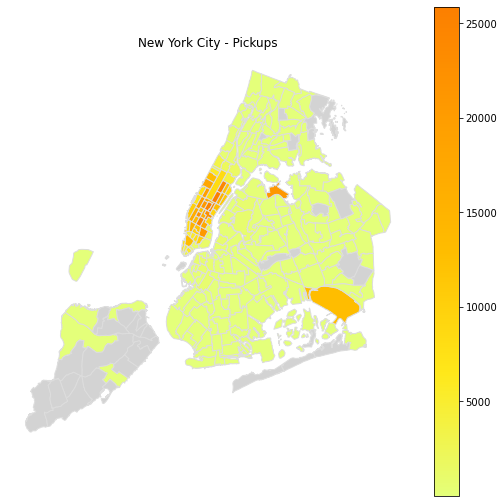

In [53]:
# trips by pickup
map_od_trips(taxi_zones, taxi_trips, False, True)

AxesSubplot(0.125,0.195485;0.62x0.61403)


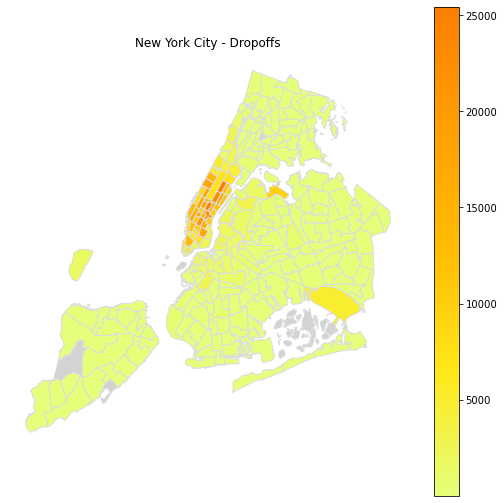

In [54]:
# trips by dropoff
map_od_trips(taxi_zones, taxi_trips, False, False)

In [55]:
# # trips by pickup/dropoff by borough
# for borough in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']:
#     map_od_trips(taxi_zones, taxi_trips.loc[taxi_trips.PU_borough==borough], borough, True)
#     map_od_trips(taxi_zones, taxi_trips.loc[taxi_trips.DO_borough==borough], borough, False)

These maps highlight how most trips are being made in Manhattan, especially in midtown. Brooklyn and Bronx trips are concentrated around centers with more density and office buildings. And many trips in Queens are headed to Laguardia or JFK airport.

#### Mapping trips in time

When are people taking taxis? Can we make asumptions on the purpose of the trip based on when they are departing and arriving?

In [56]:
def sns_heatmap(df, time_field, agg_col, agg_type):
    # new fields with pickup/dropoff day of week and hour of day
    df['day'] = df[time_field].apply(lambda x: x.weekday())
    df['hour'] = df[time_field].apply(lambda x: x.hour)
    
    # group data on day and hour fields, aggregate on agg_col by agg_type
    df = df.groupby(['day', 'hour']).agg({agg_col:agg_type}).reset_index()
    
    # create pivot table that forms basis of heatmap, re-format columns
    data = df.pivot("day", "hour", agg_col)
    data.index = data.index.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
    data.columns = data.columns.map({0:'12AM', 1:'1AM', 2:'2AM', 3:'3AM', 4:'4AM', 5:'5AM', 6:'6AM', 
                                     7:'7AM', 8:'8AM', 9:'9AM', 10:'10AM', 11:'11AM', 12:'12PM', 
                                     13:'1PM', 14:'2PM', 15:'3PM', 16:'4PM', 17:'5PM', 18:'6PM', 
                                     19:'7PM', 20:'8PM', 21:'9PM', 22:'10PM', 23:'11PM'})
    
    # plot heatmap                            
    fig, ax = plt.subplots(figsize=(12,4))
    ax = sns.heatmap(data, cmap="YlGnBu")
    print(ax)

AxesSubplot(0.125,0.125;0.62x0.755)


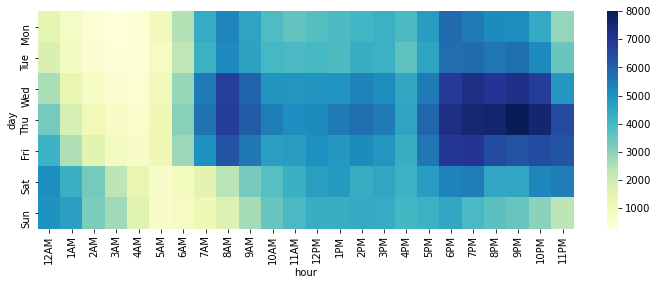

In [57]:
# plot heatmap of trips by pickup location
sns_heatmap(taxi_trips, 'tpep_pickup_datetime', 'sum_total', 'count')

I am spoting a couple typical trip-making periods. The first is the AM and PM weekday peaks where people are going to work. Another big one is evenings from Thursday-Saturday, where people are likely going out to dinner or events. They may not be driving themselves because they are drinking.

AxesSubplot(0.125,0.125;0.62x0.755)


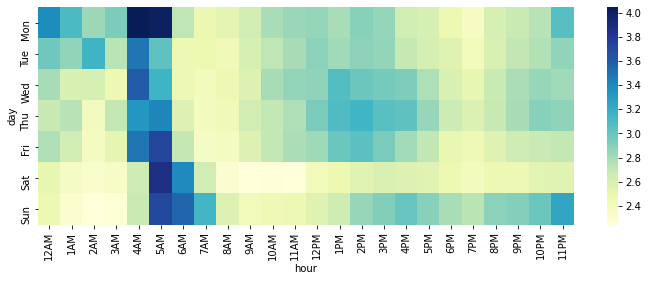

In [58]:
# plot heatmap of mean tip by pickup location
sns_heatmap(taxi_trips, 'tpep_pickup_datetime', 'tip_amount', 'mean')

People tend to tip more on average off-peak, especially early in the morning. Sunday night also sees higher than average tips, and Saturday afternoon is a very bad time for tipping.

Let's look at a couple more trip patterns.

AxesSubplot(0.125,0.125;0.62x0.755)


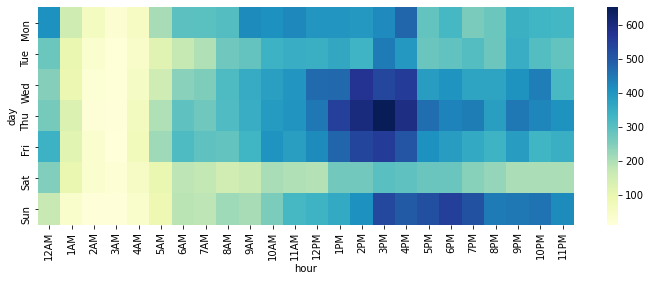

In [59]:
# plot heatmap of trips that are going to an aiport
sns_heatmap(taxi_trips.loc[taxi_trips.airport==1].copy(), 'tpep_dropoff_datetime', 'sum_total', 'count')

AxesSubplot(0.125,0.125;0.62x0.755)


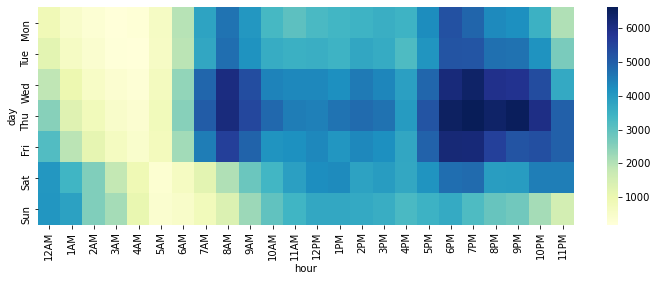

In [60]:
# plot heatmap of trips that occurred inside manhattan
sns_heatmap(taxi_trips.loc[taxi_trips.intra_Manhattan==1].copy(), 'tpep_pickup_datetime', 'sum_total', 'count')

Unsurprisingly this looks like the heatmap of all trips, mainly because most trips are occuring within Manhattan. Lots of business to go to!

AxesSubplot(0.125,0.125;0.62x0.755)


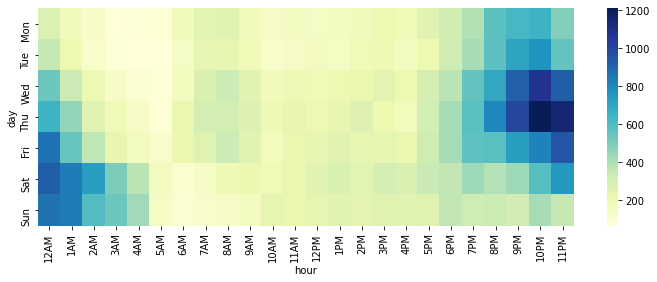

In [61]:
# plot heatmap of trips that occurred outside of manhattan and didn't go the airport
sns_heatmap(taxi_trips.loc[(taxi_trips.intra_Manhattan==0)&(taxi_trips.airport==0)].copy(), 
            'tpep_pickup_datetime', 'sum_total', 'count')

Non-airport and trips that didn't start and end in Manhattan are either 3rd shift trips or more likely social/recreational travel. Lots of night travel, with the peak spreading later in the week as people leave work earlier and stay out later.

#### Weather

How do people tip when it is raining? Data from: https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

In [62]:
weather = pd.read_csv("data/GHCND USW00094728_2017.csv")

In [63]:
taxi_trips['month'] = taxi_trips['tpep_pickup_datetime'].apply(lambda x: x.month)
taxi_trips['day'] = taxi_trips['tpep_pickup_datetime'].apply(lambda x: x.day)

In [64]:
taxi_trips = taxi_trips.merge(weather, on=['month', 'day'], how='left')

In [65]:
# sns.displot(data=taxi_trips, x="rain_flag", y="tip_amount")
print("tip (no rain):", "${:.2f}".format(taxi_trips.loc[taxi_trips.rain_flag==0].tip_amount.mean()),
                        "± {:.2f}".format(taxi_trips.loc[taxi_trips.rain_flag==0].tip_amount.std()))
print("tip (rain):", "${:.2f}".format(taxi_trips.loc[taxi_trips.rain_flag==1].tip_amount.mean()),
                     "± {:.2f}".format(taxi_trips.loc[taxi_trips.rain_flag==1].tip_amount.std()))

tip (no rain): $2.71 ± 2.66
tip (rain): $2.66 ± 2.62


It does not look like there is a statistically significant difference in tips based on whether it is raining.

## TASK 3: Model Building

*The client is launching a new ride sharing program in New York similar to Uber or Lyft. At the end of each trip they want their app to suggest a tip amount to the rider. The company has not acquired any of their own data yet, so they have tasked you with producing a model based off of the taxi data. This model should predict the likely tip amount for a trip based on the other trip attributes. You can assume that the ride sharing company can provide data that has the same attributes as the taxi data for each trip.*

*In building the model, consider the following requirements:*

- *The model should be built from the taxi dataset. You can supplement the taxi data with external datasets, but this is not a requirement.*
- *Document your choice of model / algorithm, discussing why you chose it over alternatives.*
    - *Document how you assess your models performance.*
    - *Discuss any limitations or caveats of the model which might be an issue in implementing it.*
    - *Discuss how you might improve your model going forward.*
- *Discuss how you might turn this model in to an API the company can use.*

I am going to use an ordinary least squares (OLS) linear regression model to predict likely tip amounts. The main reason I am using OLS is for simplicity and applicability. It is easy to explain the results, which is highly important in a professional context. Additionally, there are likely not many parameters that influence the model (cost, distance, time) and even if they are not linear distributed I can specify the model as linear in parameters and still capture variation due to the large size of the data. 

A limitation of using a linear regression model is that it is sensitive to outliers. I have tried my best to remove errant values earlier in this notebook but outliers may persist. Another caveat is that OLS assumes causal relationships. Less passengers in a car may predict higher tips, but correlation does not equal causation and additional information is needed.

Let's start by taking a guess at some good predictors and see how they correlate to tips.

In [ ]:
variables_to_plot=['tip_amount', 'trip_distance', 'travel_time', 'fare_amount', 'passenger_count']
sns.pairplot(taxi_trips[variables_to_plot], corner=True)

Let's create some variables to better capture variation seen in the above plots.

In [66]:
# maybe logarithmic distances and times are more appropriate
taxi_trips['trip_distance_ln'] = taxi_trips['trip_distance'].apply(lambda x: math.log(x))
taxi_trips['travel_time_ln'] = taxi_trips['travel_time'].apply(lambda x: math.log(x))

In [67]:
# surcharge flag
taxi_trips['surcharge_flag'] = np.where(taxi_trips.extra>0,1,0)
taxi_trips['surcharge_flag'] = np.where(taxi_trips.mta_tax>0,1,taxi_trips.surcharge_flag)
taxi_trips['surcharge_flag'] = np.where(taxi_trips.improvement_surcharge>0,1,taxi_trips.surcharge_flag)

# trip date/time
taxi_trips['pickup_dow'] = taxi_trips.tpep_pickup_datetime.apply(lambda x: x.weekday())
taxi_trips['pickup_hour'] = taxi_trips.tpep_pickup_datetime.apply(lambda x: x.hour)
taxi_trips['weekday_am_peak'] = np.where(taxi_trips.pickup_dow<5,
                                     np.where(taxi_trips.pickup_hour>6,
                                              np.where(taxi_trips.pickup_hour<10,1,0),0),0)
taxi_trips['weekday_pm_peak'] = np.where(taxi_trips.pickup_dow<5,
                                     np.where(taxi_trips.pickup_hour>16,
                                              np.where(taxi_trips.pickup_hour<19,1,0),0),0)

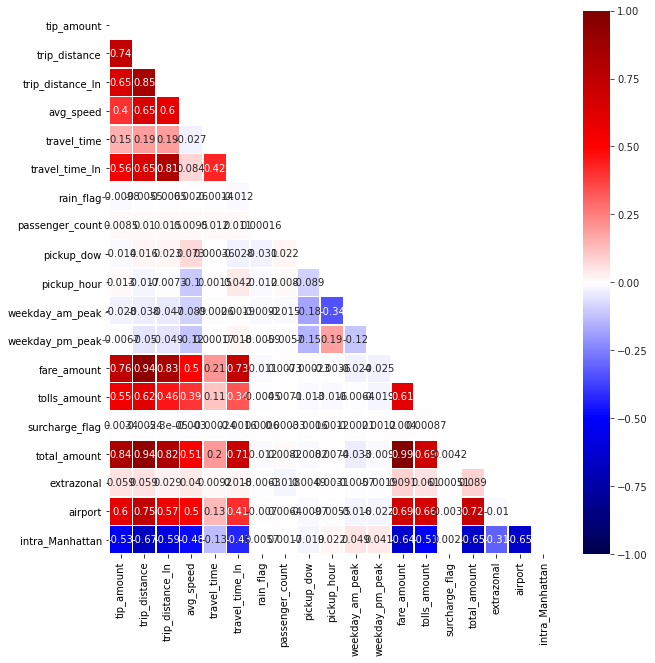

In [79]:
# define columns for correlation computation
cols = ['tip_amount', 'trip_distance', 'trip_distance_ln', 'avg_speed',
        'travel_time', 'travel_time_ln', 'rain_flag',
        'passenger_count', 'pickup_dow', 'pickup_hour', 
        'weekday_am_peak', 'weekday_pm_peak',
        'fare_amount', 'tolls_amount', 'surcharge_flag', 'total_amount',
        'extrazonal', 'airport', 'intra_Manhattan']
data_for_correlation_computation = taxi_trips[cols].copy()

# calculate correlations
corr_df = data_for_correlation_computation.corr()
corr_array = corr_df.values

# generate mask for upper triange
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate correlation heat map
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("ticks"):
    axplot=sns.heatmap(corr_df, mask=mask, annot=True, 
                       linewidths=.6, linecolor="white", cmap="seismic", vmin=-1, vmax=1)

I can select the variables to train my model from above, selecitng the ones with greatest correlation to `tip_amount`.

In [72]:
data = taxi_trips.loc[:,['tip_amount', 'fare_amount',
                         'travel_time_ln','trip_distance',
                         'airport', 'intra_Manhattan']]
data.dropna(inplace=True)
data_train, data_test = train_test_split(data, test_size=0.2,random_state=20)

In [73]:
expr = 'tip_amount ~ fare_amount + travel_time_ln + trip_distance + airport + intra_Manhattan'
model = ols(expr, data=data_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 1.595e+05
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:28:36   Log-Likelihood:            -1.0456e+06
No. Observations:              541623   AIC:                         2.091e+06
Df Residuals:                  541617   BIC:                         2.091e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3767      0.028    -

I am pretty happy with this model. All of the coefficients have the proper signs (we expect longer trips and trips to the airport to correlate to higher tips) and are significant. The value for R-squared is reasonable for a linear regression model.

I may be able to further improve the model by adding in other variables from outside the dataset. I thought that presence of rain may play a role but it may require more specific data (hourly precipitation flag?). Another piece of data that could be interesting would be a mode-choice survey. A logit model may be able to capture why people are taking a taxi and give more insight into tip amounts due to trip purpose and rationale.

I also started to include some variables that measure trip origin/destination (`airport`, `intra_Manhattan`) but may be able to improve the model with more specific travel patterns. That may turn into more of a routing algorithm though.

For now let's test the model's prediction power.

In [74]:
ols_predictions = results.get_prediction(data_test.drop(columns=['tip_amount']))
predictions_summary_frame = ols_predictions.summary_frame()
y_predict = predictions_summary_frame['mean']

print('Mean squared error: %.2f' % mean_squared_error(data_test[['tip_amount']], y_predict))
print('Coefficient of determination: %.2f' % r2_score(data_test[['tip_amount']], y_predict))

Mean squared error: 3.33
Coefficient of determination: 0.55


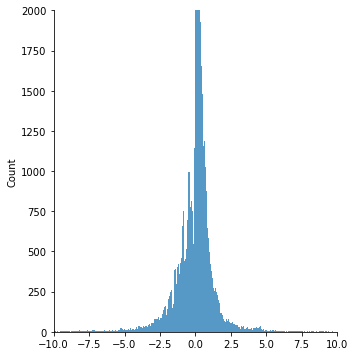

In [75]:
g = sns.displot(data_test['tip_amount'].reset_index().tip_amount - y_predict)
g.set(xlim=(-10,10))
g.set(ylim=(0, 2000))

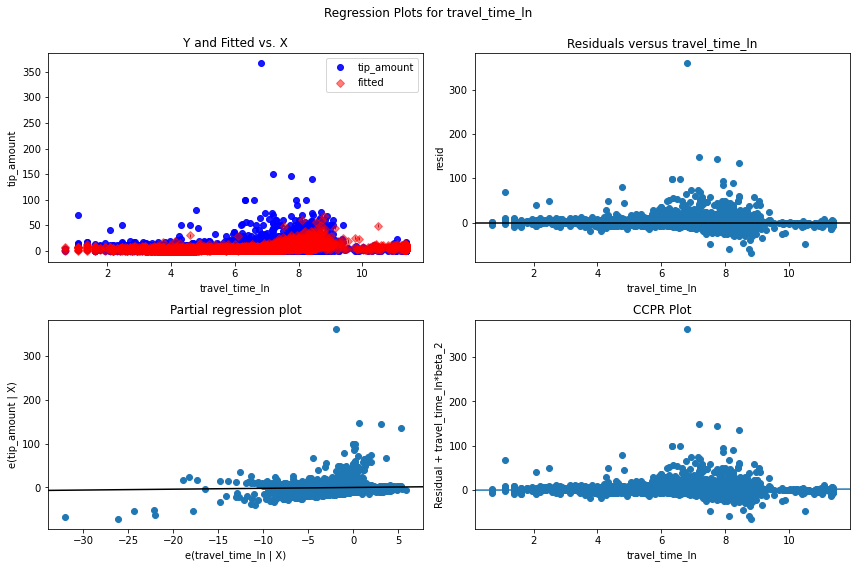

In [76]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results, 'travel_time_ln', fig=fig)

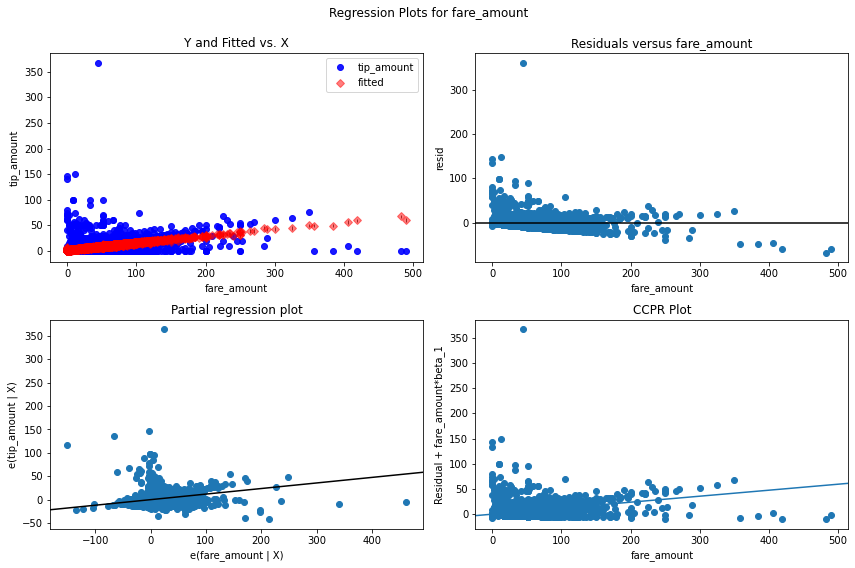

In [77]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results, 'fare_amount', fig=fig)

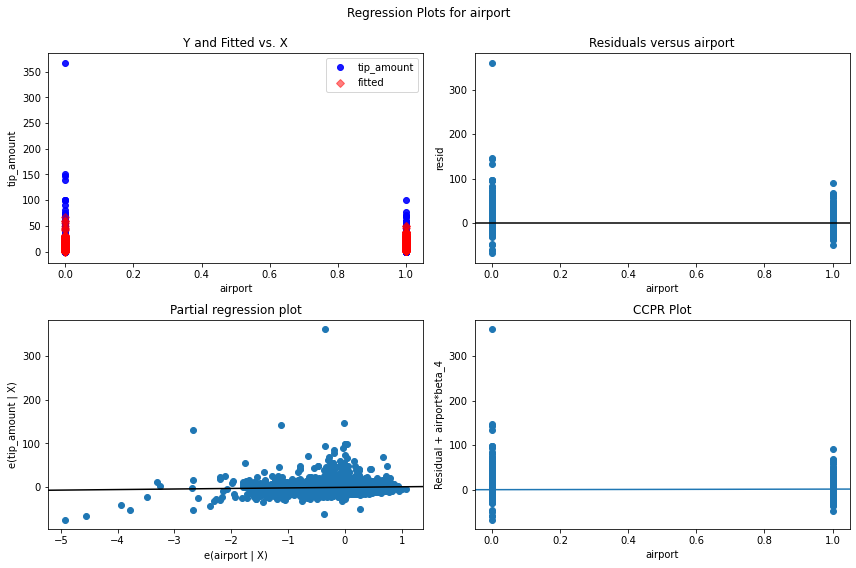

In [78]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results, 'airport', fig=fig)

The model could better capture some variables. It does look like it is underpredicting tips...the bell curve above should be centered on zero but leans positive. It could be improved to better predict people giving high tips for short trips, but I am happy with it's performance. 

Moving forward, if I were to turn this into an API for the company I would focus on packaging the model portion of this notebook. The API should be able to quickly process the trip information when the ride ends (distance, travel time, total fare) and spit out two or three best fit tip suggestions. However, I question the utility of such a tool given the typical tipping habits observed earlier. Many people tend to tip at values of 15%, 18%, and 20% because they are societal norms. Displaying these without trying to predict any trip-related values may be the most appropriate. Behavioral science may even suggest displaying higher tip options (i.e. 18%, 20%, and 25%) to encourage more generous tips and support drivers.